# Nocturna - MobileNetV3 Binary Classifier Training

This notebook trains a MobileNetV3 model to classify images as:
- **Label 0**: Photographs (not suitable for inverting)
- **Label 1**: Charts/Plots (suitable for inverting in dark mode)

## 1. Import Libraries

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"timm version: {timm.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu128
timm version: 1.0.22
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Ti


## 2. Explore Available MobileNetV3 Models

In [28]:
# List all available MobileNetV3 models in timm
mobilenet_models = timm.list_models('*mobilenetv3*', pretrained=True)
print("Available MobileNetV3 models:")
for model_name in mobilenet_models:
    print(f"  - {model_name}")

Available MobileNetV3 models:
  - mobilenetv3_large_100.miil_in21k
  - mobilenetv3_large_100.miil_in21k_ft_in1k
  - mobilenetv3_large_100.ra4_e3600_r224_in1k
  - mobilenetv3_large_100.ra_in1k
  - mobilenetv3_large_150d.ra4_e3600_r256_in1k
  - mobilenetv3_rw.rmsp_in1k
  - mobilenetv3_small_050.lamb_in1k
  - mobilenetv3_small_075.lamb_in1k
  - mobilenetv3_small_100.lamb_in1k
  - tf_mobilenetv3_large_075.in1k
  - tf_mobilenetv3_large_100.in1k
  - tf_mobilenetv3_large_minimal_100.in1k
  - tf_mobilenetv3_small_075.in1k
  - tf_mobilenetv3_small_100.in1k
  - tf_mobilenetv3_small_minimal_100.in1k


## 3. Load Pre-trained MobileNetV3 Model

In [29]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained MobileNetV3-Large with binary classification head
model_name = 'mobilenetv3_large_100'
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=2  # Binary classification: 0 (photos) or 1 (plots)
)

model = model.to(device)
print(f"\nModel '{model_name}' loaded successfully!")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

Model 'mobilenetv3_large_100' loaded successfully!
Number of parameters: 4,204,594


## 4. Inspect Model Architecture

In [30]:
# Get model configuration
data_config = timm.data.resolve_model_data_config(model)
print("Model data configuration:")
print(f"  Input size: {data_config['input_size']}")
print(f"  Mean: {data_config['mean']}")
print(f"  Std: {data_config['std']}")
print(f"  Interpolation: {data_config['interpolation']}")
print(f"  Crop percentage: {data_config['crop_pct']}")

Model data configuration:
  Input size: (3, 224, 224)
  Mean: (0.485, 0.456, 0.406)
  Std: (0.229, 0.224, 0.225)
  Interpolation: bicubic
  Crop percentage: 0.875


In [31]:
# Print model summary (classifier head)
print("\nClassifier head:")
print(model.classifier)


Classifier head:
Linear(in_features=1280, out_features=2, bias=True)


## 5. Create Data Transforms

In [32]:
# Create transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_config['mean'], std=data_config['std'])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_config['mean'], std=data_config['std'])
])

print("Data transforms created successfully!")

Data transforms created successfully!


## 6. Test Model with Random Input

In [33]:
# Test the model with a random input
model.eval()
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")
    print(f"Raw output (logits): {output}")
    
    # Apply sigmoid for binary classification probabilities
    probs = torch.sigmoid(output)
    print(f"Probabilities: {probs}")
    print(f"Predicted class: {(probs > 0.5).long().item()}")

Output shape: torch.Size([1, 2])
Raw output (logits): tensor([[ 0.4335, -0.6107]], device='cuda:0')
Probabilities: tensor([[0.6067, 0.3519]], device='cuda:0')


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

## 5. Model training setup

Dataset Structure:
  data/label_0: 9144 images
  data/graphs: 15859 images


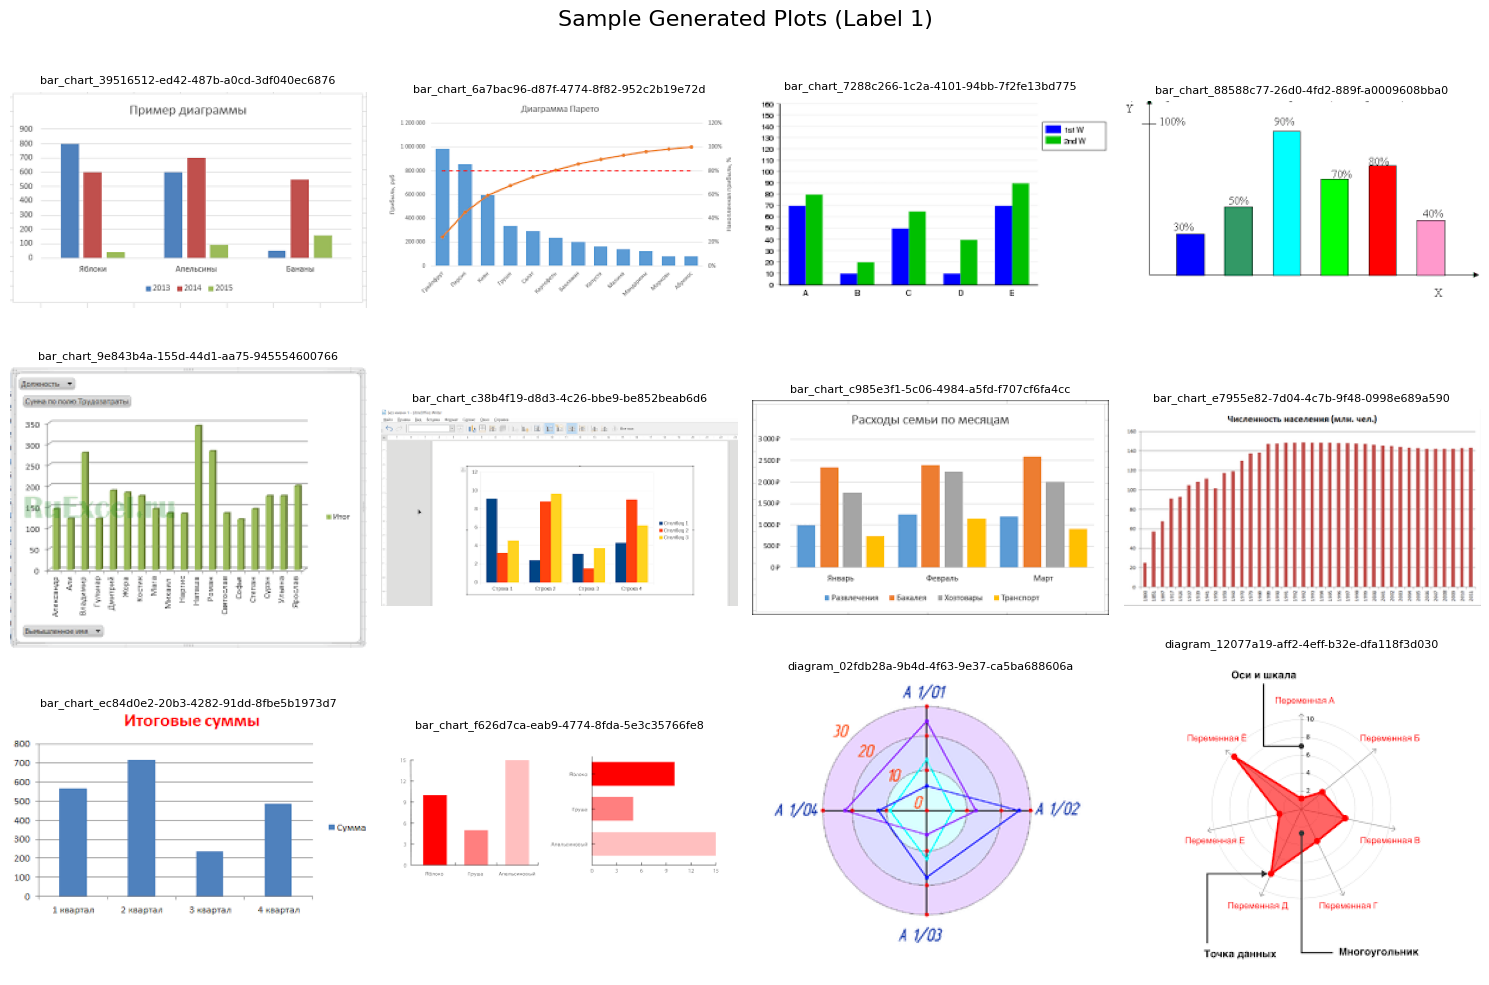

In [36]:
# Check dataset structure
import os

data_dir = Path('data')
label_0_dir = data_dir / 'label_0'  # Photos (to be filled)
label_1_dir = data_dir / 'graphs'  # Generated plots

print("Dataset Structure:")
print(f"  {label_0_dir}: {len(list(label_0_dir.glob('*.png')) + list(label_0_dir.glob('*.jpg')))} images")
print(f"  {label_1_dir}: {len(list(label_1_dir.glob('*.png')) + list(label_1_dir.glob('*.jpg')))} images")

# Show sample plots
plot_files = sorted(list(label_1_dir.glob('*.png')))[:12]
if plot_files:
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    fig.suptitle('Sample Generated Plots (Label 1)', fontsize=16)
    for idx, (ax, img_path) in enumerate(zip(axes.flat, plot_files)):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.stem, fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo plots found in label_1 directory!")

In [38]:
class NocturnaDataset(Dataset):
    """
    Custom dataset for Nocturna binary classification.
    Label 0: Photos (not suitable for inverting)
    Label 1: Plots/Charts (suitable for inverting in dark mode)
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []

        # Load label_0 (photos)
        label_0_dir = self.data_dir / 'label_0'
        if label_0_dir.exists():
            for ext in ['*.png', '*.jpg', '*.jpeg']:
                for img_path in label_0_dir.glob(ext):
                    self.samples.append((img_path, 0))

        # Load label_1 (plots)
        label_1_dir = self.data_dir / 'graphs'
        if label_1_dir.exists():
            for ext in ['*.png', '*.jpg', '*.jpeg']:
                for img_path in label_1_dir.glob(ext):
                    self.samples.append((img_path, 1))

        print(f"Loaded {len(self.samples)} images:")
        print(f"  - Label 0 (photos): {sum(1 for _, label in self.samples if label == 0)}")
        print(f"  - Label 1 (plots): {sum(1 for _, label in self.samples if label == 1)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [39]:
from sklearn.model_selection import train_test_split

# Create full dataset
full_dataset = NocturnaDataset('data', transform=None)

# Get all samples and labels
all_samples = full_dataset.samples

# Split: 70% train, 15% val, 15% test
train_samples, temp_samples = train_test_split(
    all_samples, test_size=0.3, random_state=42,
    stratify=[label for _, label in all_samples]
)
val_samples, test_samples = train_test_split(
    temp_samples, test_size=0.5, random_state=42,
    stratify=[label for _, label in temp_samples]
)

print(f"Dataset split:")
print(f"  Train: {len(train_samples)} samples")
print(f"  Val: {len(val_samples)} samples")
print(f"  Test: {len(test_samples)} samples")

Loaded 25005 images:
  - Label 0 (photos): 9144
  - Label 1 (plots): 15861
Dataset split:
  Train: 17503 samples
  Val: 3751 samples
  Test: 3751 samples


In [40]:
# Create custom datasets for each split
class SubsetDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets with appropriate transforms
train_dataset = SubsetDataset(train_samples, transform=train_transform)
val_dataset = SubsetDataset(val_samples, transform=val_transform)
test_dataset = SubsetDataset(test_samples, transform=val_transform)

In [41]:
# Set batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Train batches: 547
  Val batches: 118
  Test batches: 118


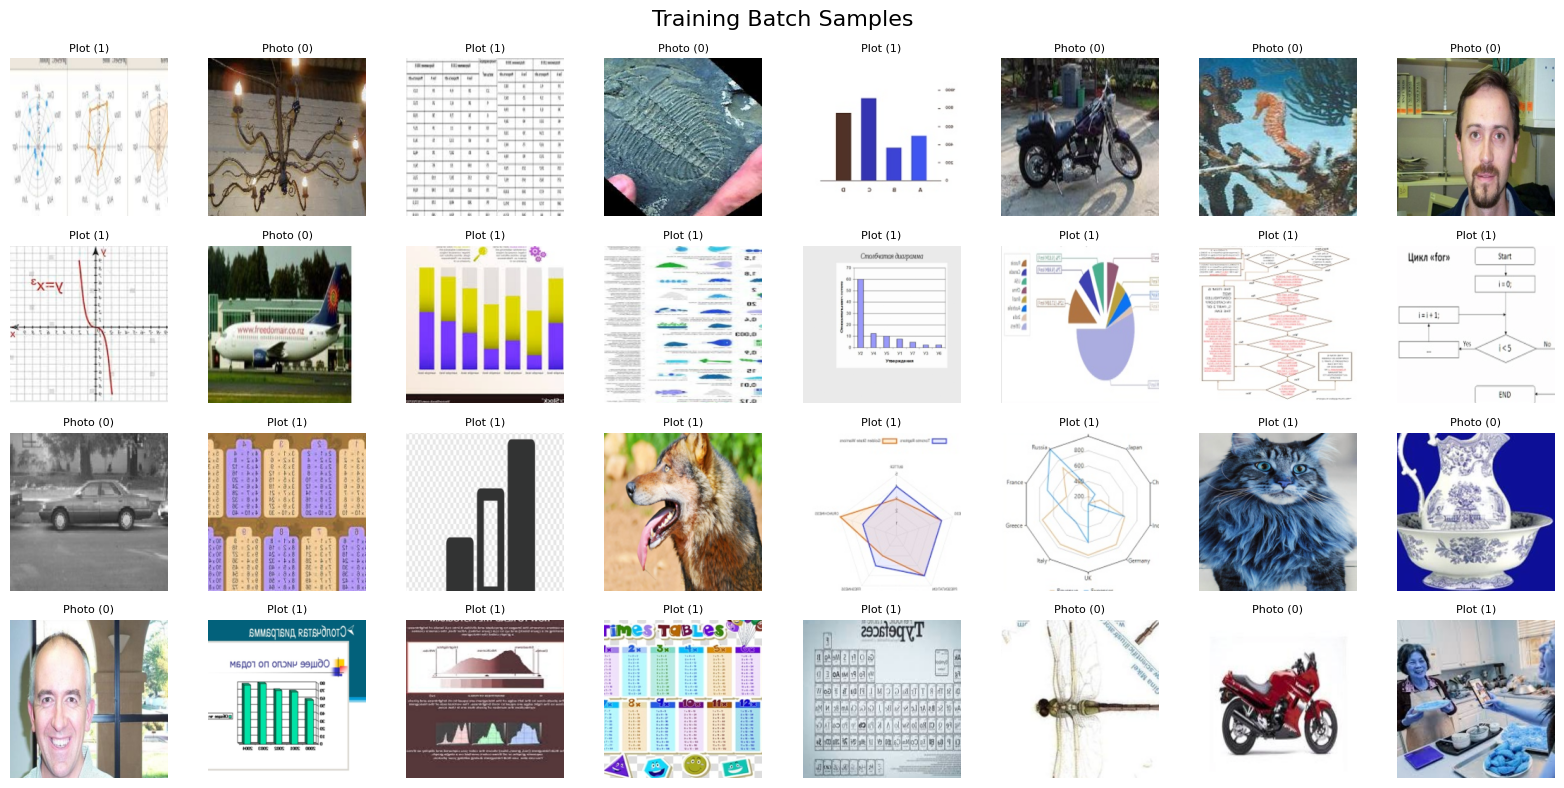

In [42]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Denormalize for visualization
mean = torch.tensor(data_config['mean']).view(3, 1, 1)
std = torch.tensor(data_config['std']).view(3, 1, 1)

def denormalize(img):
    return img * std + mean

# Plot samples
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Training Batch Samples', fontsize=16)

for idx, (ax, img, label) in enumerate(zip(axes.flat, images[:32], labels[:32])):
    img_denorm = denormalize(img).permute(1, 2, 0).numpy()
    img_denorm = np.clip(img_denorm, 0, 1)
    ax.imshow(img_denorm)
    label_name = 'Photo' if label.item() == 0 else 'Plot'
    ax.set_title(f'{label_name} ({label.item()})', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Loss function - Binary Cross Entropy with Logits
criterion = nn.CrossEntropyLoss()

# Optimizer - AdamW with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Learning rate scheduler - ReduceLROnPlateau
# verbose removed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, 
)

print("Training setup:")
print(f"  Loss function: {criterion.__class__.__name__}")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Initial learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Scheduler: {scheduler.__class__.__name__}")

Training setup:
  Loss function: CrossEntropyLoss
  Optimizer: AdamW
  Initial learning rate: 0.0001
  Scheduler: ReduceLROnPlateau


In [44]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [45]:
# Training configuration
num_epochs = 20
best_val_acc = 0.0
best_model_path = 'best_model.pth'

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, best_model_path)
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

    print()

print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 36.55it/s, loss=1.0126, acc=96.53%]



Epoch 1 Summary:
  Train Loss: 0.3713 | Train Acc: 93.44%
  Val Loss: 0.1627 | Val Acc: 96.53%
  Learning Rate: 0.000100
  ✓ Best model saved! (Val Acc: 96.53%)

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.22it/s, loss=0.2787, acc=97.36%]



Epoch 2 Summary:
  Train Loss: 0.0936 | Train Acc: 97.61%
  Val Loss: 0.1071 | Val Acc: 97.36%
  Learning Rate: 0.000100
  ✓ Best model saved! (Val Acc: 97.36%)

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.53it/s, loss=2.3105, acc=96.77%]



Epoch 3 Summary:
  Train Loss: 0.0503 | Train Acc: 98.42%
  Val Loss: 0.1224 | Val Acc: 96.77%
  Learning Rate: 0.000100

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.77it/s, loss=0.0004, acc=97.97%]



Epoch 4 Summary:
  Train Loss: 0.0368 | Train Acc: 98.90%
  Val Loss: 0.0823 | Val Acc: 97.97%
  Learning Rate: 0.000100
  ✓ Best model saved! (Val Acc: 97.97%)

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.42it/s, loss=0.1010, acc=97.84%]



Epoch 5 Summary:
  Train Loss: 0.0218 | Train Acc: 99.25%
  Val Loss: 0.1035 | Val Acc: 97.84%
  Learning Rate: 0.000100

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.26it/s, loss=0.1292, acc=98.08%]



Epoch 6 Summary:
  Train Loss: 0.0212 | Train Acc: 99.25%
  Val Loss: 0.0996 | Val Acc: 98.08%
  Learning Rate: 0.000100
  ✓ Best model saved! (Val Acc: 98.08%)

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.49it/s, loss=0.0024, acc=97.92%]



Epoch 7 Summary:
  Train Loss: 0.0204 | Train Acc: 99.40%
  Val Loss: 0.0972 | Val Acc: 97.92%
  Learning Rate: 0.000100

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.30it/s, loss=0.0907, acc=97.95%]



Epoch 8 Summary:
  Train Loss: 0.0170 | Train Acc: 99.49%
  Val Loss: 0.1006 | Val Acc: 97.95%
  Learning Rate: 0.000050

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.50it/s, loss=0.0668, acc=98.24%]



Epoch 9 Summary:
  Train Loss: 0.0116 | Train Acc: 99.66%
  Val Loss: 0.0857 | Val Acc: 98.24%
  Learning Rate: 0.000050
  ✓ Best model saved! (Val Acc: 98.24%)

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.67it/s, loss=0.0081, acc=98.21%]



Epoch 10 Summary:
  Train Loss: 0.0058 | Train Acc: 99.75%
  Val Loss: 0.1017 | Val Acc: 98.21%
  Learning Rate: 0.000050

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 37.73it/s, loss=0.0370, acc=98.13%]



Epoch 11 Summary:
  Train Loss: 0.0064 | Train Acc: 99.78%
  Val Loss: 0.1004 | Val Acc: 98.13%
  Learning Rate: 0.000050

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.37it/s, loss=0.0034, acc=98.19%]



Epoch 12 Summary:
  Train Loss: 0.0068 | Train Acc: 99.78%
  Val Loss: 0.1044 | Val Acc: 98.19%
  Learning Rate: 0.000025

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.27it/s, loss=0.0072, acc=98.43%]



Epoch 13 Summary:
  Train Loss: 0.0040 | Train Acc: 99.84%
  Val Loss: 0.0863 | Val Acc: 98.43%
  Learning Rate: 0.000025
  ✓ Best model saved! (Val Acc: 98.43%)

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 37.85it/s, loss=0.0011, acc=98.32%]



Epoch 14 Summary:
  Train Loss: 0.0032 | Train Acc: 99.91%
  Val Loss: 0.0900 | Val Acc: 98.32%
  Learning Rate: 0.000025

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.32it/s, loss=0.2558, acc=98.32%]



Epoch 15 Summary:
  Train Loss: 0.0024 | Train Acc: 99.93%
  Val Loss: 0.0965 | Val Acc: 98.32%
  Learning Rate: 0.000025

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.37it/s, loss=0.3167, acc=98.48%]



Epoch 16 Summary:
  Train Loss: 0.0022 | Train Acc: 99.92%
  Val Loss: 0.0890 | Val Acc: 98.48%
  Learning Rate: 0.000013
  ✓ Best model saved! (Val Acc: 98.48%)

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.19it/s, loss=0.2702, acc=98.24%]



Epoch 17 Summary:
  Train Loss: 0.0017 | Train Acc: 99.95%
  Val Loss: 0.0878 | Val Acc: 98.24%
  Learning Rate: 0.000013

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.20it/s, loss=0.7190, acc=98.35%]



Epoch 18 Summary:
  Train Loss: 0.0022 | Train Acc: 99.94%
  Val Loss: 0.0813 | Val Acc: 98.35%
  Learning Rate: 0.000013

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.26it/s, loss=0.3204, acc=98.37%]



Epoch 19 Summary:
  Train Loss: 0.0011 | Train Acc: 99.96%
  Val Loss: 0.0945 | Val Acc: 98.37%
  Learning Rate: 0.000013

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 118/118 [00:03<00:00, 38.23it/s, loss=0.5262, acc=98.35%]


Epoch 20 Summary:
  Train Loss: 0.0015 | Train Acc: 99.94%
  Val Loss: 0.0904 | Val Acc: 98.35%
  Learning Rate: 0.000013

Training complete! Best validation accuracy: 98.48%


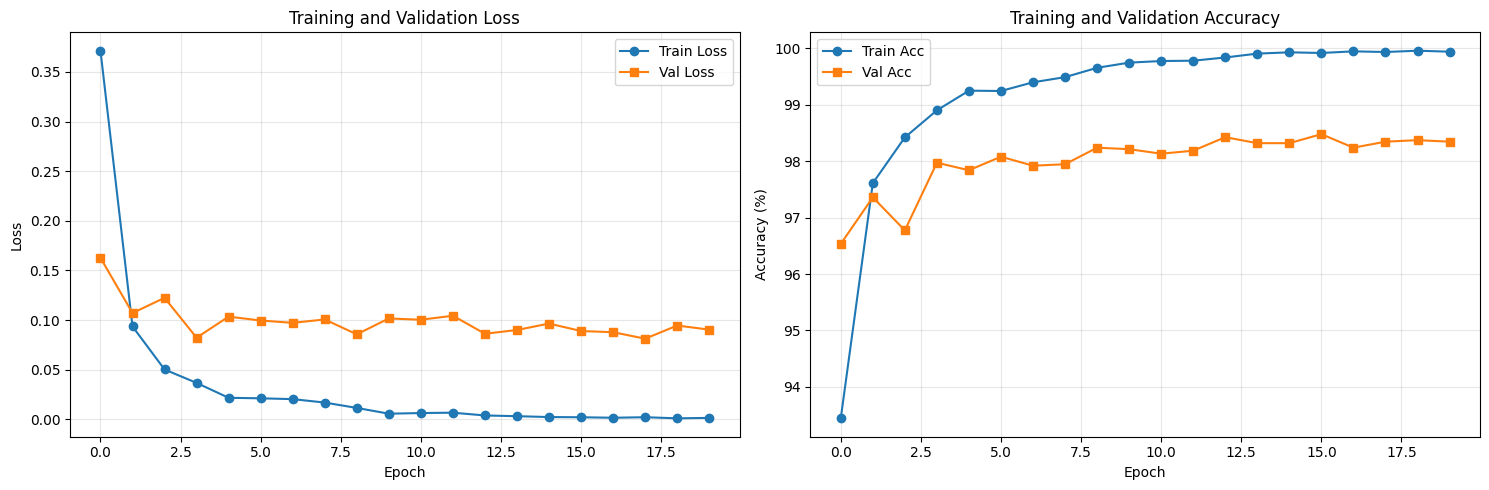

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss9893c907fa889bcbc14a5f3a86e527176f0f02be
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Loaded best model from epoch 16


Testing: 100%|██████████| 118/118 [00:02<00:00, 40.03it/s]



Classification Report:
              precision    recall  f1-score   support

  Photos (0)     0.9760    0.9789    0.9774      1372
   Plots (1)     0.9878    0.9861    0.9870      2379

    accuracy                         0.9835      3751
   macro avg     0.9819    0.9825    0.9822      3751
weighted avg     0.9835    0.9835    0.9835      3751



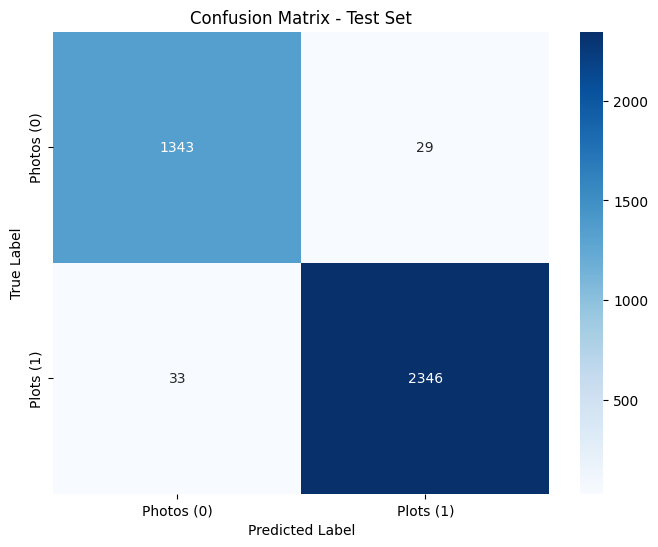

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(
    all_labels, all_preds,
    target_names=['Photos (0)', 'Plots (1)'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Photos (0)', 'Plots (1)'],
            yticklabels=['Photos (0)', 'Plots (1)'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [48]:
# Save final model with complete information
final_model_path = 'nocturna_mobilenetv3.pth'

torch.save({
    'model_name': model_name,
    'model_state_dict': model.state_dict(),
    'data_config': data_config,
    'best_val_acc': best_val_acc,
    'history': history,
    'class_names': ['photos', 'plots']
}, final_model_path)

print(f"✓ Final model saved to {final_model_path}")
print(f"  Model: {model_name}")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")

✓ Final model saved to nocturna_mobilenetv3.pth
  Model: mobilenetv3_large_100
  Best validation accuracy: 98.48%
